In [ ]:
# import os
# import argparse
# import torch
# import pandas as pd
# import numpy as np
# import scipy.io as sio
# from torch.utils.data import DataLoader
# from torchvision import transforms
# import cv2
# import sys
# from scipy.signal import windows

# sys.path.append('/home/siming/physformer')

# from physformer.model.physformer import ViT_ST_ST_Compact3_TDC_gra_sharp
# from loadtemporal_data_test import Normaliztion, ToTensor, VIPL

# def FeatureMap2Heatmap(x, Score1, Score2, Score3, log_dir, prefix=""):
#     org_img = x[0,:,32,:,:].cpu().data.numpy() * 128 + 127.5
#     org_img = org_img.transpose((1,2,0))
#     #cv2.imwrite(f"{log_dir}/{prefix}visual.jpg", org_img)

#     for idx, Score in enumerate([Score1, Score2, Score3], 1):
#         org_img = Score[0, 1].cpu().data.numpy() * 4000
#         org_img = cv2.cvtColor(org_img, cv2.COLOR_GRAY2RGB)
#         #cv2.imwrite(f"{log_dir}/{prefix}Score{idx}_head1.jpg", org_img)

# def overlap_add(prev, new, overlap_len):
#     """
#     用 Hanning 窗函数对两个 clip 的 overlap 部分做加权拼接
#     prev: 当前累计的拼接序列
#     new: 新 clip 的波形
#     overlap_len: 重叠部分长度
#     """
#     if overlap_len == 0:
#         return np.concatenate([prev, new])
    
#     # 重叠部分
#     left = prev[-overlap_len:]
#     right = new[:overlap_len]

#     w = windows.hann(overlap_len * 2)
#     left_w = w[:overlap_len]
#     right_w = w[overlap_len:]

#     blended = left * left_w + right * right_w

#     merged = np.concatenate([prev[:-overlap_len], blended, new[overlap_len:]])
#     return merged

# def run_inference(args):
#     os.makedirs(args.log, exist_ok=True)
#     log_file = open(f"{args.log}/{args.log}_log.txt", "w")

#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(f"[INFO] Using device: {device}")

#     VIPL_root_list = os.path.join(args.input_data, 'VIPL_frames')
#     VIPL_test_list = os.path.join(args.input_data, 'sample_info_20.csv')
#     model_path = os.path.join(args.input_data, 'Physformer_VIPL_fold1.pkl')

#     model = ViT_ST_ST_Compact3_TDC_gra_sharp(
#         image_size=(160,128,128),
#         patches=(4,4,4),
#         dim=96, ff_dim=144, num_heads=4, num_layers=12,
#         dropout_rate=0.1, theta=0.7
#     )
#     gra_sharp = 2.0
#     model = model.to(device)
#     model.load_state_dict(torch.load(model_path, map_location=device))
#     model.eval()

#     dataset = VIPL(
#         info_list=VIPL_test_list,
#         root_dir=VIPL_root_list,
#         transform=transforms.Compose([Normaliztion(), ToTensor()]),
#         clip_size=args.clip_size,
#         clip_overlap=args.clip_overlap,
#         single_file=args.single_file
#     )
#     dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

#     results_rPPG = []
#     results_HR = []

#     prev_file_name = None
#     rPPG_long = []
#     framerate = 30.0

#     video_count = 0
#     total_videos = len(set([clip['row']['file_name'] for clip in dataset.valid_clips]))

#     with torch.no_grad():
#         for i, batch in enumerate(dataloader):
#             inputs = batch['video_x'].to(device).permute(0,2,1,3,4)
#             file_name = batch['file_name'][0]
#             gt_hr = float(batch['clip_average_HR_peaks'].cpu().numpy()[0])
#             framerate = float(batch['framerate'].cpu().numpy()[0])

#             rPPG, Score1, Score2, Score3 = model(inputs, gra_sharp)
#             rPPG_clip = rPPG[0].cpu().numpy()

#             FeatureMap2Heatmap(inputs, Score1, Score2, Score3, args.log, prefix=f"{file_name}_clip{i+1}_")

#             if prev_file_name is None:
#                 prev_file_name = file_name

#             if prev_file_name == file_name:
#                 if len(rPPG_long) == 0:
#                     rPPG_long = rPPG_clip
#                 else:
#                     rPPG_long = overlap_add(rPPG_long, rPPG_clip, args.clip_overlap)
#             else:
#                 # Save previous video result
#                 freqs = np.fft.rfftfreq(len(rPPG_long), d=1/framerate)
#                 fft = np.abs(np.fft.rfft(rPPG_long))
#                 peak_freq = freqs[np.argmax(fft[1:])+1]
#                 pred_HR = peak_freq * 60

#                 results_rPPG.append(rPPG_long)
#                 results_HR.append({'file_name': prev_file_name, 'pred_HR': pred_HR, 'gt_HR': gt_hr})

#                 video_count += 1
#                 print(f"[INFO] Finished video {video_count}/{total_videos}: {prev_file_name}, Pred HR: {pred_HR:.2f} BPM, GT HR: {gt_hr:.2f} BPM")
#                 log_file.write(f"[{prev_file_name}] Pred HR: {float(pred_HR):.2f} | GT HR: {float(gt_hr):.2f}\n")
#                 log_file.flush()

#                 # Start new video
#                 rPPG_long = rPPG_clip
#                 prev_file_name = file_name

#         # Don't forget the last video
#         if len(rPPG_long) > 0:
#             freqs = np.fft.rfftfreq(len(rPPG_long), d=1/framerate)
#             fft = np.abs(np.fft.rfft(rPPG_long))
#             peak_freq = freqs[np.argmax(fft[1:])+1]
#             pred_HR = peak_freq * 60

#             results_rPPG.append(rPPG_long)
#             results_HR.append({'file_name': prev_file_name, 'pred_HR': pred_HR, 'gt_HR': gt_hr})

#             video_count += 1
#             print(f"[INFO] Finished video {video_count}/{total_videos}: {prev_file_name}, Pred HR: {pred_HR:.2f} BPM, GT HR: {gt_hr:.2f} BPM")
#             log_file.write(f"[{prev_file_name}] Pred HR: {float(pred_HR):.2f} | GT HR: {float(gt_hr):.2f}\n")
#             log_file.flush()

#     results_rPPG_arr = np.empty(len(results_rPPG), dtype=object)
#     results_rPPG_arr[:] = results_rPPG
#     sio.savemat(f"{args.log}/outputs_rPPG_concat.mat", {'outputs_rPPG': results_rPPG_arr})

#     pd.DataFrame(results_HR).to_csv(f"{args.log}/HR_results.csv", index=False)

#     log_file.close()
#     print(f"[INFO] Finished inference. Saved results to {args.log}")

# if __name__ == "__main__":
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--input_data', type=str, default="/home/siming/physformer")
#     parser.add_argument('--log', type=str, default="Inference_Physformer")
#     parser.add_argument('--clip_size', type=int, default=160)
#     parser.add_argument('--clip_overlap', type=int, default=60)
#     parser.add_argument('--single_file', type=str, default=None)
#     args, unknown = parser.parse_known_args()

#     run_inference(args)


[INFO] Using device: cpu
[INFO] Total valid samples (after clip split): 95


/tmp/ipykernel_696115/2943073755.py:97: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gt_hr = float(batch['clip_average_HR_peaks'].cpu().numpy()[0])
/tmp/ipykernel_696115/2943073755.py:98: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  framerate = float(batch['framerate'].cpu().numpy()[0])


[INFO] Finished video 1/19: 959-20230426212426785_tmp_9ccc62b1c0a18b14c8093ab0ea545e64251a62c158ac692b.mp4, Pred HR: 70.71 BPM
[INFO] Finished video 2/19: 960-20230429085552277_tmp_2a736f45b9eebe4bb981b5fc0ce8b6bdcb88e4b48e80af8f.mp4, Pred HR: 80.36 BPM
[INFO] Finished video 3/19: 961-20230430105934489_tmp_4c82a31346fa76a44676eb96fbc1210538b1dcad768dd8cf.mp4, Pred HR: 61.07 BPM
[INFO] Finished video 4/19: 962-20230503154237807_tmp_33d1a2a4f5af8f20dccd2af618224a6cddd02b449be70942.mp4, Pred HR: 77.14 BPM
[INFO] Finished video 5/19: 963-20230506065854701_tmp_a61b26ec2446c9718217337536210772d6f9203fac212e25.mp4, Pred HR: 70.71 BPM
[INFO] Finished video 6/19: 964-20230507113549029_tmp_b82d377839287729379678ae91b4b0e993b6caf7ed1fb463.mp4, Pred HR: 70.71 BPM
[INFO] Finished video 7/19: 965-20230606191610794_tmp_58fa604c7fc77323839b98ab2a4ead14110430da3b989082.mp4, Pred HR: 67.50 BPM
[INFO] Finished video 8/19: 966-20230611090941376_tmp_83fe8dbd5ea4fdd39ab90394da511c47f10d648ed783d959.mp4, Pre

In [14]:
import os
import cv2
import shutil
import pandas as pd
import math
import torch
import numpy as np
import scipy.io as sio
from torch.utils.data import DataLoader
from torchvision import transforms
from scipy.signal import windows


import sys

sys.path.append('/home/siming/physformer')

from physformer.model.physformer import ViT_ST_ST_Compact3_TDC_gra_sharp
from loadtemporal_data_test import Normaliztion, ToTensor, VIPL


def video2frames(video_name, video_dir, save_dir, csv_fps, csv_frame_cnt, target_fps=30, log_file=None):
    video_path = os.path.join(video_dir, video_name)
    cap = cv2.VideoCapture(video_path)
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        msg = f"[SKIP] Cannot read frames for: {video_name}"
        print(msg)
        if log_file: log_file.write(msg + '\n')
        return False

    if abs(total_frames - csv_frame_cnt) > 2:
        msg = f"[WARNING] Frame count mismatch: CSV={csv_frame_cnt}, Actual={total_frames}"
        print(msg)
        if log_file: log_file.write(msg + '\n')

    os.makedirs(save_dir, exist_ok=True)
    step = original_fps / target_fps

    frame_idx = 0
    save_idx = 0

    while True:
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_idx))
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (132, 132))[2:130, 2:130, :]
        save_name = f"image_{save_idx:05d}.png"
        save_path = os.path.join(save_dir, save_name)
        cv2.imwrite(save_path, frame)

        frame_idx += step
        save_idx += 1
        if int(frame_idx) >= total_frames:
            break

    cap.release()
    msg = f"[INFO] Saved {save_idx} frames to {save_dir}"
    print(msg)
    if log_file: log_file.write(msg + '\n')
    return True


def overlap_add(prev, new, overlap_len):
    if overlap_len == 0:
        return np.concatenate([prev, new])

    left = prev[-overlap_len:]
    right = new[:overlap_len]

    w = windows.hann(overlap_len * 2)
    left_w = w[:overlap_len]
    right_w = w[overlap_len:]

    blended = left * left_w + right * right_w

    merged = np.concatenate([prev[:-overlap_len], blended, new[overlap_len:]])
    return merged


def run_inference(args):
    os.makedirs(args.log, exist_ok=True)
    log_file = open(os.path.join(args.log, "inference_log.txt"), "w")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    msg = f"[INFO] Using device: {device}"
    print(msg)
    log_file.write(msg + '\n')
    log_file.flush()

    video_dir = args.video_dir
    csv_info = args.csv_info
    output_root = os.path.join(args.input_data, 'VIPL_frames')
    model_path = os.path.join(args.input_data, 'Physformer_VIPL_fold1.pkl')

    model = ViT_ST_ST_Compact3_TDC_gra_sharp(
        image_size=(160,128,128),
        patches=(4,4,4),
        dim=96, ff_dim=144, num_heads=4, num_layers=12,
        dropout_rate=0.1, theta=0.7
    )
    model = model.to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    gra_sharp = 2.0

    df = pd.read_csv(csv_info)
    df.columns = df.columns.str.strip()

    results_rPPG = []
    results_HR = []

    all_videos = df['file_name'].unique().tolist()
    total_videos = len(all_videos)
    video_count = 0

    for idx, row in df.iterrows():
        video_name = str(row['file_name']).strip()
        if not video_name.endswith('.mp4'):
            video_name += '.mp4'

        fps_val = row['fps']
        frame_cnt_val = row['frame_cnt']
        gt_hr = float(row['hr_true'])

        if pd.isna(fps_val) or math.isnan(fps_val) or pd.isna(frame_cnt_val) or math.isnan(frame_cnt_val):
            continue

        csv_fps = float(fps_val)
        csv_frame_cnt = int(frame_cnt_val)
        video_path = os.path.join(video_dir, video_name)
        if not os.path.exists(video_path):
            continue

        msg = f"\n[INFO] Processing {video_name} ({video_count+1}/{total_videos})"
        print(msg)
        log_file.write(msg + '\n')
        log_file.flush()

        # === Step 1: 转帧 ===
        save_dir = os.path.join(output_root, video_name.replace('.mp4',''))
        if os.path.exists(save_dir):
            shutil.rmtree(save_dir)
        ok = video2frames(video_name, video_dir, save_dir, csv_fps, csv_frame_cnt, target_fps=30, log_file=log_file)
        if not ok:
            continue

        # === Step 2: Dataset & DataLoader ===
        dataset = VIPL(
            info_list=csv_info,
            root_dir=output_root,
            transform=transforms.Compose([Normaliztion(), ToTensor()]),
            clip_size=args.clip_size,
            clip_overlap=args.clip_overlap,
            single_file=video_name
        )
        dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

        rPPG_long = []
        framerate = 30.0

        for i, batch in enumerate(dataloader):
            inputs = batch['video_x'].to(device).permute(0,2,1,3,4)
            rPPG, _, _, _ = model(inputs, gra_sharp)
            rPPG_clip = rPPG[0].detach().cpu().numpy()
            if len(rPPG_long) == 0:
                rPPG_long = rPPG_clip
            else:
                rPPG_long = overlap_add(rPPG_long, rPPG_clip, args.clip_overlap)

        freqs = np.fft.rfftfreq(len(rPPG_long), d=1/framerate)
        fft = np.abs(np.fft.rfft(rPPG_long))
        peak_freq = freqs[np.argmax(fft[1:])+1]
        pred_HR = peak_freq * 60

        results_rPPG.append(rPPG_long)
        results_HR.append({'file_name': video_name, 'pred_HR': pred_HR, 'gt_HR': gt_hr})

        video_count += 1
        msg = f"[INFO] Finished {video_name} ({video_count}/{total_videos}): Pred HR = {pred_HR:.2f} | GT HR = {gt_hr:.2f}"
        print(msg)
        log_file.write(msg + '\n')
        log_file.flush()

        # === Step 3: 删除帧 ===
        shutil.rmtree(save_dir)
        msg = f"[INFO] Deleted frames: {save_dir}"
        print(msg)
        log_file.write(msg + '\n')
        log_file.flush()

    results_rPPG_arr = np.empty(len(results_rPPG), dtype=object)
    results_rPPG_arr[:] = results_rPPG
    sio.savemat(f"{args.log}/outputs_rPPG_concat.mat", {'outputs_rPPG': results_rPPG_arr})
    pd.DataFrame(results_HR).to_csv(f"{args.log}/HR_results.csv", index=False)

    msg = f"[INFO] All done. Saved results to {args.log}"
    print(msg)
    log_file.write(msg + '\n')
    log_file.flush()
    log_file.close()

if __name__ == "__main__":
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--input_data', type=str, default="/home/siming/physformer")
    parser.add_argument('--video_dir', type=str, default="/mnt/vdb/sample_video")
    parser.add_argument('--csv_info', type=str, default="/home/siming/physformer/sample_info.csv")
    parser.add_argument('--log', type=str, default="Inference_Physformer")
    parser.add_argument('--clip_size', type=int, default=160)
    parser.add_argument('--clip_overlap', type=int, default=60)
    args, unknown = parser.parse_known_args()

    run_inference(args)


[INFO] Using device: cpu

[INFO] Processing 959-20230426212426785_tmp_9ccc62b1c0a18b14c8093ab0ea545e64251a62c158ac692b.mp4 (1/1603)


KeyboardInterrupt: 

                                           file_name    pred_HR  gt_HR
0  959-20230426212426785_tmp_9ccc62b1c0a18b14c809...  70.714286   73.0
1  960-20230429085552277_tmp_2a736f45b9eebe4bb981...  80.357143   70.0
2  961-20230430105934489_tmp_4c82a31346fa76a44676...  61.071429   72.0
3  962-20230503154237807_tmp_33d1a2a4f5af8f20dccd...  77.142857   80.0
4  963-20230506065854701_tmp_a61b26ec2446c9718217...  70.714286   81.0
[INFO] Columns: ['file_name', 'pred_HR', 'gt_HR']


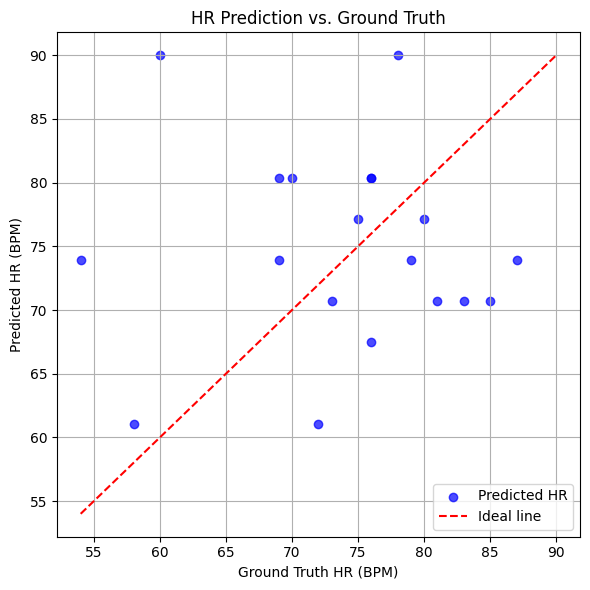

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. 读取 CSV ===
df = pd.read_csv('/home/siming/Inference_Physformer/HR_results.csv')

print(df.head())

# 如果你的列是 'file_name','pred_HR','gt_HR' 就 OK
# 如果你要检查也可以：
print("[INFO] Columns:", df.columns.tolist())

# === 2. 画散点图 ===
plt.figure(figsize=(6, 6))
plt.scatter(df['gt_HR'], df['pred_HR'], color='blue', alpha=0.7, label='Predicted HR')

# 理想对角线
min_hr = min(df['gt_HR'].min(), df['pred_HR'].min())
max_hr = max(df['gt_HR'].max(), df['pred_HR'].max())
plt.plot([min_hr, max_hr], [min_hr, max_hr], 'r--', label='Ideal line')

plt.xlabel('Ground Truth HR (BPM)')
plt.ylabel('Predicted HR (BPM)')
plt.title('HR Prediction vs. Ground Truth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 3. 也可保存图 ===
# plt.savefig('scatter_hr_results.png', dpi=300)


[INFO] MAE: 9.58 BPM


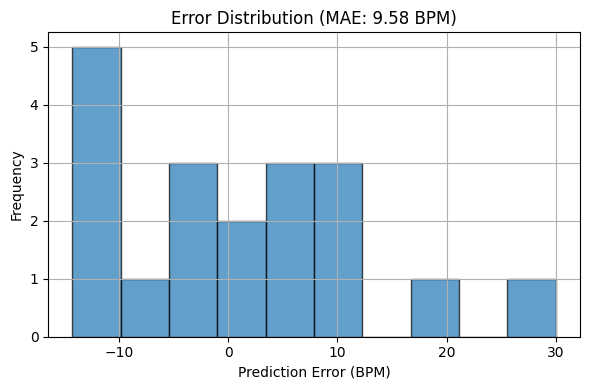

In [13]:
errors = df['pred_HR'] - df['gt_HR']
mae = abs(errors).mean()
print(f"[INFO] MAE: {mae:.2f} BPM")

plt.figure(figsize=(6,4))
plt.hist(errors, bins=10, alpha=0.7, edgecolor='k')
plt.xlabel('Prediction Error (BPM)')
plt.ylabel('Frequency')
plt.title(f'Error Distribution (MAE: {mae:.2f} BPM)')
plt.grid(True)
plt.tight_layout()
plt.show()
